In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate, constrain_stationary_multivariate)


In [303]:
class PersistentDividendModel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, k_states, k_posdef):
        """
        Parameters:
        - endog: array-like, shape (n_obs, n_series)
        - k_states: number of states
        - k_posdef: dimension of the state innovation vector
        """

        measurement_var = np.var(endog, axis=0) 
        state_var = np.array([4900, 4900, 4900, measurement_var[3], measurement_var[2], measurement_var[4], measurement_var[0], measurement_var[1], 0, 0, 0, 0, 0])

        # Initialize the base class (MLEModel)
        super().__init__(endog, k_states=k_states, k_posdef=k_posdef, initialization='known', initial_state=np.zeros(13), initial_state_cov=np.diag(state_var))

        self.nobs, self.n_series = self.endog.shape

        # Design matrix Z: shape (n_series, k_states)
        self['design'] = self.buildH(40, 0.967, np.full(5, .5),np.full(5, .5))

        # Transition matrix T: shape (k_states, k_states)
        self['transition'] = self.buildF(np.full(5, .5), np.full(5, .5))

        # Selection matrix R: shape (k_states, k_posdef)
        self['selection'] = np.ones((k_states, k_posdef))

        # State covariance matrix Q: shape (k_posdef, k_posdef)
        self['state_cov'] = self.buildQ(np.ones(8))

        # Observation covariance matrix H: shape (n_series, n_series)
        self['obs_cov'] = np.eye(self.n_series)


    def update(self, params, **kwargs):
        """
        Update the parameters in the state space matrices given `params`.
        """

        params = np.array(params)
        # Design matrix Z: shape (n_series, k_states)
        self['design'] = self.buildH(40, 0.967, params[0:5] , params[5:10])

        # Transition matrix T: shape (k_states, k_states)
        self['transition'] = self.buildF(params[0:5] , params[5:10])

        # Observation covariance matrix H: shape (n_series, n_series)
        self['obs_cov'] = np.diag(params[10:15])

        # State covariance matrix Q: shape (k_posdef, k_posdef)
        self['state_cov'] = self.buildQ(params[15:])

    @property
    def start_params(self):
        """
        Initial guess of parameters.
        """
        ar = np.full(10, .5)
        measurement_var = np.var(self.endog, axis=0) * 0.1
        state_var = np.array([measurement_var[3], measurement_var[2], measurement_var[4], measurement_var[3], measurement_var[2], measurement_var[4], measurement_var[0], measurement_var[1]]) * 9

        return np.concatenate((ar, measurement_var, state_var))

    def transform_params(self, unconstrained):
        """
        Map unconstrained parameters to constrained space.
        E.g., variances must be positive.
        """
        constrained = unconstrained.copy() 
        #constrained[0:10] = constrain_stationary_univariate(unconstrained[0:10])
        constrained[10:] = unconstrained[10:] ** 2

        return constrained

    def untransform_params(self, constrained):
        """
        Map constrained parameters back to unconstrained space.
        """
        unconstrained = constrained.copy()
        #unconstrained[0:10] = unconstrain_stationary_univariate(constrained[0:10])
        unconstrained[10:] = unconstrained[10:] ** 0.5

        return unconstrained
        
    @property
    def param_names(self):
        """
        Names for each parameter for reference.
        """
        
        state_names = ["dp", "rp", "πp", "da", "ra", "πa", "ea", "τa"]
        observations_names = ["p", "il", "is", "d", "π"]

        # Equivalent of Julia's state_names[::4] (i.e., every 4th element starting at index 0)
        ar_names = [f"θ{lag}_{v}" for lag in range(1, 3) for v in state_names[3:]]
        measurement_sigmas = [f"σ_{n}" for n in observations_names]
        states_sigmas = [f"v{n}" for n in state_names]

        return ar_names + measurement_sigmas + states_sigmas

    
    def buildH(self, n, rho, theta1, theta2):
        Hp = np.array([
            1 / (1 - rho),
            -1 / (1 - rho),
            0,
            theta1[0] / (1 - rho * theta1[0]),
            -theta1[1] / (1 - rho * theta1[1]),
            0,
            -theta1[3] / (1 - rho * theta1[3]),
            0,
            theta2[0] / (1 - rho * theta2[0]),
            -theta2[1] / (1 - rho * theta2[1]),
            0,
            -theta2[3] / (1 - rho * theta2[3]),
            0
        ])

        Hin = np.array([
            0,
            1,
            1,
            0,
            (1 / n) * ((1 - theta1[1]**n) / (1 - theta1[1])) * theta1[1],
            (1 / n) * ((1 - theta1[2]**n) / (1 - theta1[2])) * theta1[2],
            0,
            (1 / n) * ((1 - theta1[4]**(n - 1)) / (1 - theta1[4])) * theta1[4],
            0,
            (1 / n) * ((1 - theta2[1]**n) / (1 - theta2[1])) * theta2[1],
            (1 / n) * ((1 - theta2[2]**n) / (1 - theta2[2])) * theta2[2],
            0,
            (1 / n) * ((1 - theta2[4]**(n - 1)) / (1 - theta2[4])) * theta2[4]
        ])

        Hi = np.array([
            0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0
        ])

        Hd = np.array([
            1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0
        ])

        Hpi = np.array([
            0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0
        ])

        H = np.vstack([Hp, Hin, Hi, Hd, Hpi])
        return H
    
    def buildF(self, theta1, theta2):
        I3 = np.eye(3)
        I5 = np.eye(5)
        Z35 = np.zeros((3, 5))
        Z53 = np.zeros((5, 3))
        Z55 = np.zeros((5, 5))
        D1 = np.diag(theta1)
        D2 = np.diag(theta2)

        top = np.hstack((I3, Z35, Z35))
        middle = np.hstack((Z53, D1, D2))
        bottom = np.hstack((Z53, I5, Z55))

        return np.vstack((top, middle, bottom))
    
    def buildQ(self, Q):
        result = np.zeros((13, 13))
        cov_matrix = np.diag(Q)
        result[:8, :8] = cov_matrix
        return result


In [225]:
data_source = pd.read_excel("usa_var_data.xlsx")
data_source.set_index("Date", inplace=True)

data_quarterly = data_source[["Yeld_10Y", "T_Bill", "Dividend", "Stock_Price", "CPI"]].resample('Q').last()

data_quarterly[["Yeld_10Y", "T_Bill"]] = data_quarterly[["Yeld_10Y", "T_Bill"]] / 4

data_quarterly["CPIQ"] = data_quarterly["CPI"].pct_change()

data_quarterly["DivGrowth"] = data_quarterly["Dividend"].pct_change() - data_quarterly["CPIQ"]

data_quarterly["P/D"] = np.log(data_quarterly["Stock_Price"]/data_quarterly["Dividend"])

data_quarterly = data_quarterly.loc["1953-06-30":"1999-03-31"] 

data = data_quarterly[["P/D", "Yeld_10Y", "T_Bill", "DivGrowth", "CPIQ"]] - data_quarterly[["P/D", "Yeld_10Y", "T_Bill", "DivGrowth", "CPIQ"]].mean()



data = data * 100
display(data_quarterly[["P/D", "Yeld_10Y", "T_Bill", "DivGrowth", "CPIQ"]].mean())
display(data.tail(10))
np.round(data.describe(), decimals=4)


P/D          3.372585
Yeld_10Y     0.016942
T_Bill       0.013688
DivGrowth    0.003453
CPIQ         0.010044
dtype: float64

,P/D,Yeld_10Y,T_Bill,DivGrowth,CPIQ
Date,,,,,
1996-12-31,56.395252,-0.086721,-0.141332,0.596402,-0.499072
1997-03-31,55.164042,0.035779,-0.083832,-0.100452,-0.313053
1997-06-30,73.512889,-0.066721,-0.136332,0.285004,-0.817176
1997-09-30,75.159399,-0.164221,-0.131332,0.086524,-0.319084
1997-12-31,75.378173,-0.256721,-0.078832,0.715995,-1.004442
1998-03-31,88.467014,-0.276721,-0.111332,0.383932,-0.447511
1998-06-30,90.700592,-0.334221,-0.123832,0.917253,-0.573673
1998-09-30,78.417089,-0.584221,-0.216332,0.101015,-0.514246
1998-12-31,96.718745,-0.531721,-0.271332,0.193204,-0.821515


,P/D,Yeld_10Y,T_Bill,DivGrowth,CPIQ
count,184.0000,184.0000,184.0000,184.0000,184.0000
mean,-0.0000,0.0000,0.0000,0.0000,-0.0000
std,29.4709,0.7067,0.7087,1.2988,0.8650
min,-59.7922,-1.0917,-1.2088,-4.5835,-1.9169
25%,-20.1314,-0.6343,-0.5051,-0.8957,-0.5624
50%,1.4297,-0.0180,-0.1001,-0.0796,-0.1660
75%,14.2869,0.3339,0.3999,0.7739,0.3259
max,102.3596,2.2658,2.5037,4.2714,3.1087


In [304]:
model = PersistentDividendModel(data, 13, 13)

res = model.fit()

res.summary()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\matsz\AppData\Local\Temp\ipykernel_24008\552813032.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:8, :8] = cov_matrix
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           Statespace Model Results                                           
==============================================================================================================
Dep. Variable:     ['P/D', 'Yeld_10Y', 'T_Bill', 'DivGrowth', 'CPIQ']   No. Observations:                  184
Model:                                        PersistentDividendModel   Log Likelihood               -2428.085
Date:                                                Thu, 24 Apr 2025   AIC                           4902.170
Time:                                                        22:22:48   BIC                           4976.113
Sample:                                                    06-30-1953   HQIC                          4932.140
                                                         - 03-31-1999                                         
Covariance Type:                                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
θ1_da         -0.4659      0.487     -0.956      0.339      -1.421       0.489
θ1_ra          0.5860      1.199      0.489      0.625      -1.764       2.936
θ1_πa          0.1384      1.006      0.138      0.891      -1.834       2.111
θ1_ea          0.0441      0.006      7.594      0.000       0.033       0.055
θ1_τa          0.2342     17.486      0.013      0.989     -34.038      34.506
θ2_da         -0.4649      0.394     -1.179      0.238      -1.238       0.308
θ2_ra          0.7069      1.424      0.496      0.620      -2.085       3.499
θ2_πa          0.4037      0.759      0.532      0.595      -1.085       1.892
θ2_ea          1.0185      0.001    817.172      0.000       1.016       1.021
θ2_τa          0.3275     12.044      0.027      0.978     -23.279      23.934
σ_p          130.6059     10.068     12.973      0.000     110.873     150.338
σ_il           0.0236      0.007      3.443      0.001       0.010       0.037
σ_is           0.1139      0.048      2.384      0.017       0.020       0.207
σ_d            1.8188      0.164     11.066      0.000       1.497       2.141
σ_π            0.4920      0.045     11.027      0.000       0.405       0.579
vdp            1.4900         -0       -inf      0.000       1.490       1.490
vrp            0.2559         -0       -inf      0.000       0.256       0.256
vπp            0.7134         -0       -inf      0.000       0.713       0.713
vda            1.4900         -0       -inf      0.000       1.490       1.490
vra            0.2559         -0       -inf      0.000       0.256       0.256
vπa            0.7134         -0       -inf      0.000       0.713       0.713
vea          760.0148         -0       -inf      0.000     760.015     760.015
vτa            0.2023         -0       -inf      0.000       0.202       0.202
==================================================================================================================
Ljung-Box (L1) (Q):     121.50, 148.86, 104.98, 75.08, 57.18   Jarque-Bera (JB):   10.59, 3.87, 24.65, 3.15, 10.34
Prob(Q):                        0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):              0.01, 0.14, 0.00, 0.21, 0.01
Heteroskedasticity (H):         0.89, 0.82, 6.73, 0.28, 0.61   Skew:                -0.57, -0.32, 0.35, 0.26, 0.41
Prob(H) (two-sided):            0.64, 0.45, 0.00, 0.00, 0.06   Kurtosis:              3.32, 3.33, 4.65, 3.38, 3.82
==================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstabl

In [305]:
np.sqrt(res.params[15:] / 100)

vdp    0.122064
vrp    0.050589
vπp    0.084462
vda    0.122064
vra    0.050589
vπa    0.084462
vea    2.756837
vτa    0.044982
dtype: float64

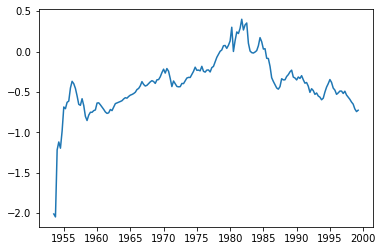

In [339]:
filter = res.filter_results
plt.plot(data.index, filter.filtered_state[0])


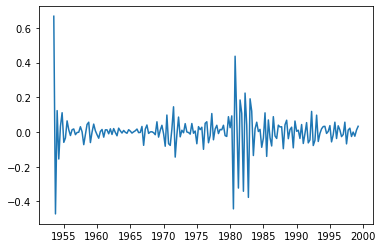

In [340]:
plt.plot(data.index, filter.filtered_state[3])

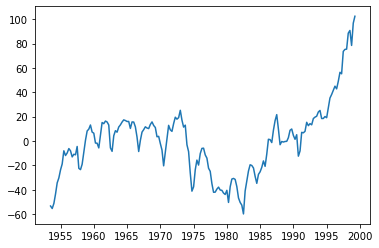

In [341]:
plt.plot(data.iloc[:,0])

Text(0.5, 1.0, 'dp')

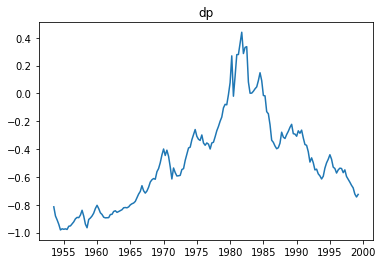

In [347]:

plt.plot(data.index, res.smoothed_state[0])
plt.title("dp")

Text(0.5, 1.0, 'da')

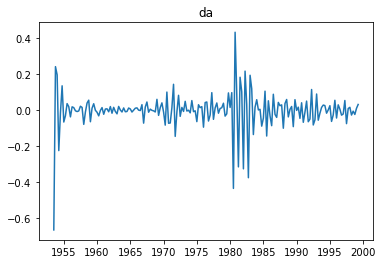

In [345]:
plt.plot(data.index, res.smoothed_state[3])
plt.title("da")

Text(0.5, 1.0, 'ea')

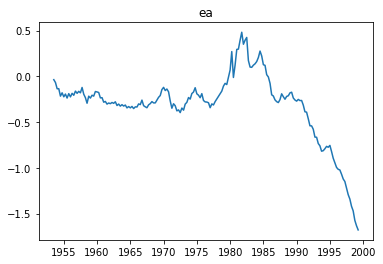

In [344]:
plt.plot(data.index, res.smoothed_state[6])
plt.title("ea")

Text(0.5, 1.0, 'rp')

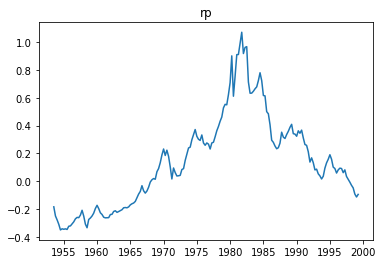

In [349]:
plt.plot(data.index, res.smoothed_state[1])
plt.title("rp")

Text(0.5, 1.0, 'ra')

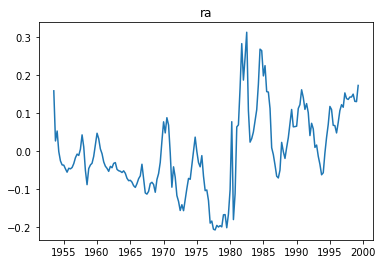

In [351]:
plt.plot(data.index, res.smoothed_state[4])
plt.title("ra")

Text(0.5, 1.0, 'pi_p')

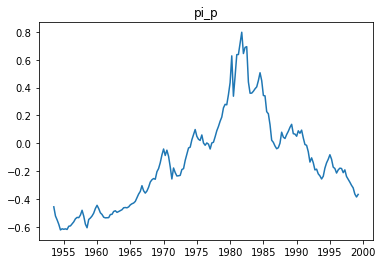

In [352]:
plt.plot(data.index, res.smoothed_state[2])
plt.title("pi_p")

Text(0.5, 1.0, 'pia')

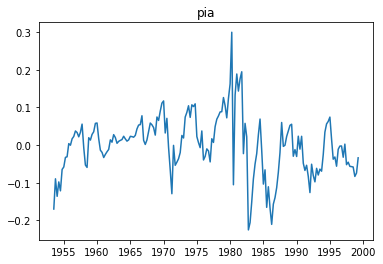

In [353]:
plt.plot(data.index, res.smoothed_state[5])
plt.title("pia")

Text(0.5, 1.0, 'tau_a')

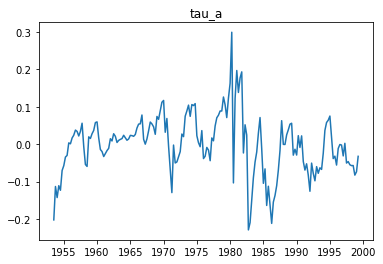

In [354]:
plt.plot(data.index, res.smoothed_state[7])
plt.title("tau_a")

In [140]:
# Θ1 and Θ2 as NumPy arrays
theta1 = np.array([0.333, 0.343, 0.003, 0.528, 0.234])
theta2 = np.array([0.338, 0.286, -0.130, -0.012, 0.625])

# R as a NumPy array
R = np.array([1.45e-1, 1.59e-14, 3.01e-13, 7.43e-10, 3.78e-12])

# Q as a NumPy array, scaled by 1/100
Q = np.array([4.66e-2, 2.34e-2, 5.51e-2, 2.2, 0.5, 0.253, 62.11, 2.09]) / 100

test_params = np.r_[theta1, theta2, R, Q]
np.round(test_params, decimals=3)

test_model = PersistentDividendModel(np.full((250, 5), .1), 13, 13)

test_model.simulate(test_params, 1)

RuntimeError: Statespace model not initialized.

In [270]:
R = np.vstack((np.eye(8, 8), np.zeros((5, 8))))

R.shape

(13, 8)